In [63]:
# Ref: https://medium.com/analytics-vidhya/naive-bayes-algorithm-implementation-from-scratch-f9a2a12789b5


import tensorflow as tf
import keras
import matplotlib.pyplot as plt
#Para el preprocesamiento
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import random


#Manipulando la  data
data = pd.read_csv(r'C:\Users\Indatech\Downloads\EMG\Dataset\EMG-data.csv', delimiter=',')
  #Se agregó la r para que el código leyera el path, pues lo estaba leyendo como un string normal

print(data.shape)
##Revisa que el dataset no tenga valores vacíos o no válidos
print("\nempty values:",data.isnull().any().sum()) 

data.sample(10) #Prueba

(4237907, 11)

empty values: 0


,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,label
828227,11622,-0.00003,0.00000,-0.00009,-0.00005,-0.00008,-0.00012,0.00000,0.00025,0,8
952294,17923,0.00005,0.00009,0.00010,0.00009,-0.00012,0.00018,0.00015,0.00011,4,9
2625155,18735,0.00011,0.00013,0.00016,-0.00075,-0.00007,0.00004,0.00007,0.00009,4,22
1930595,3978,0.00002,-0.00006,-0.00004,-0.00002,-0.00001,0.00000,-0.00002,0.00000,1,17
2330217,33695,0.00019,0.00001,-0.00007,-0.00011,-0.00025,0.00015,0.00000,0.00013,6,20
1392322,60872,0.00000,0.00000,0.00000,-0.00004,-0.00001,-0.00001,-0.00001,-0.00001,0,12
3014029,55796,0.00001,-0.00005,-0.00005,-0.00002,0.00000,0.00010,-0.00002,0.00000,0,25
4072347,36759,-0.00128,-0.00053,-0.00011,-0.00002,0.00010,0.00000,0.00023,-0.00057,0,35
967061,33411,0.00000,-0.00001,-0.00001,0.00003,-0.00004,-0.00002,0.00000,0.00000,1,9
4156490,21297,0.00002,0.00018,0.00001,0.00003,0.00004,0.00004,0.00001,0.00001,0,36


In [64]:
#Ahora dropearemos las filas y columnas que no necesitamos, en este caso las de clase '0', pues no es una clasificación útil
dataset=data.drop(columns=["time"])  #No necesitamos la columna del tiempo
dataset = dataset.drop(dataset[dataset["class"] == 0].index)
dataset=dataset.drop(columns=["channel5"])  #Borra canal 5
dataset=dataset.drop(columns=["channel6"])  #Borra canal 6
dataset=dataset.drop(columns=["channel7"])  #Borra canal 7
dataset=dataset.drop(columns=["channel8"])  #Borra canal 8
dataset = dataset.drop(dataset[dataset["class"] == 0].index)
dataset = dataset.drop(dataset[dataset["class"] == 5].index)  #Borra Radial deviations
dataset = dataset.drop(dataset[dataset["class"] == 6].index)  #Borra Ulnar deviations
dataset = dataset.drop(dataset[dataset["class"] == 7].index)  #Borra Extended palm
dataset.to_csv("filtered_data.csv", index=False)

dataset.sample(5)

,channel1,channel2,channel3,channel4,class,label
1702120,0.00013,0.00003,-0.00002,0.00000,3,14
3081429,0.00019,0.00003,0.00005,0.00010,3,26
2036398,0.00001,-0.00001,-0.00006,-0.00003,3,17
759458,-0.00015,-0.00007,-0.00006,0.00010,2,7
730448,-0.00001,-0.00002,-0.00006,0.00012,3,7


In [65]:
classes = dataset["class"]

#Veamos cuántas entradas hay de cada gesto a calsificar:
print("Value Count :\n", dataset["class"].value_counts())

#Dividimos en 80% train_data y 20% test_data

if isinstance(0.2,float):  #0.2 es la porcion que queremos que sea de test (el 20%)
  test_size = round(0.2*len(dataset))

idx = dataset.index.tolist()  #Guarda los indices del dataset en una lista
test_idx = random.sample(idx, test_size)

#Creando los conjuntos de entrenamiento y de prueba a partir del dataset
test_x = dataset.loc[test_idx]
test_x = test_x.drop(columns=["label"])
train_x = dataset.drop(test_idx)
train_x = train_x.drop(columns=["label"])

#Guardando las divisiones en nuevos archivos para cada grupo
train_x.to_csv("train_x.csv", index=False)
test_x.to_csv("test_x.csv", index=False)

# Print the shapes of the training and testing sets.
print(train_x.shape)
print(test_x.shape)

Value Count :
 class
4    251570
1    250055
3    249494
2    243193
Name: count, dtype: int64
(795450, 5)
(198862, 5)


In [66]:
# Normalizando
columns_to_normalize = train_x.columns.difference(['class'])  # Excluye 'class', las clases o gestos

mean = train_x.mean(axis=0) #Valor medio
std = train_x.std(axis=0) #Desviacion estandar

train_x[columns_to_normalize] -= mean
train_x[columns_to_normalize] /= std

test_x[columns_to_normalize] -= mean
test_x[columns_to_normalize] /= std

In [67]:
print(train_x.head())

      channel1  channel2  channel3  channel4  class
2288  -0.01018 -0.071889  0.069545 -0.002535      1
2289  -0.01018 -0.071889  0.069545 -0.002535      1
2290  -0.01018 -0.071889  0.069545 -0.002535      1
2291  -0.01018 -0.071889  0.069545 -0.002535      1
2292  -0.01018 -0.071889  0.069545 -0.002535      1


In [68]:
print(test_x.head())

         channel1  channel2  channel3  channel4  class
4146438 -0.213838  0.068836 -0.073200 -0.112673      3
2814193  0.040734 -0.001527  0.140918  0.070891      1
3032064  0.448048 -0.634790 -1.572027 -0.369663      4
1402424 -0.010180 -0.071889 -0.073200  0.034178      1
451601  -0.061095 -0.071889 -0.215946 -0.039247      1


In [69]:
#Probabilidad previa de las clases

def prior_probs(data):
  prior_prob = data.groupby(by = 'class').apply(lambda x: len(x)/len(data))

  return np.log(prior_prob).values

In [70]:
train_x.head()

,channel1,channel2,channel3,channel4,class
2288,-0.01018,-0.071889,0.069545,-0.002535,1
2289,-0.01018,-0.071889,0.069545,-0.002535,1
2290,-0.01018,-0.071889,0.069545,-0.002535,1
2291,-0.01018,-0.071889,0.069545,-0.002535,1
2292,-0.01018,-0.071889,0.069545,-0.002535,1


In [71]:
test_x.head()

,channel1,channel2,channel3,channel4,class
4146438,-0.213838,0.068836,-0.073200,-0.112673,3
2814193,0.040734,-0.001527,0.140918,0.070891,1
3032064,0.448048,-0.634790,-1.572027,-0.369663,4
1402424,-0.010180,-0.071889,-0.073200,0.034178,1
451601,-0.061095,-0.071889,-0.215946,-0.039247,1


In [72]:
#TO TRAIN

# Valor medio y varianza de las señales de los distintos canales agrupados por clase
mean_values = train_x.groupby('class')[['channel1', 'channel2','channel3','channel4']].mean()
var_values = train_x.groupby('class')[['channel1', 'channel2','channel3','channel4']].var()

# Conversión de Pandas Dataframe en matriz 2D de numpy
means = np.asarray(mean_values)
vars = np.asarray(var_values)

In [73]:
import warnings
warnings.filterwarnings('ignore')

#Probabilidad Gaussiana
def gaussian_probability(data,means, var): 
  a = (1/np.sqrt(2*(np.pi)*var))
  b = np.exp(-np.square(data-means)/(2*var))
  gaussian_prob = a*b
  return gaussian_prob

def post_probabilities(data_row, mean, var, n_labels, n_cols):

    # Lista para almacenar las probabilidades posteriores calculadas para cada clase
  pos_prob = []

  # probabilidades con cada clase para encontrar el máximo
  for i in range(n_labels):
    post = 0

    # Para cada característica (columna) del conjunto de dato
    for j in range(n_cols):
      post += np.log(gaussian_probability(data_row[j], mean[i][j], var[i][j]))
    
    # Agregar la probabilidad posterior calculada para la clase actual a la lista
    pos_prob.append(post)

  return pos_prob

def fitting(data):
    #obtiene el numero de columnas del dataset
  n_cols = len(data.columns)-1
    #clases unicas
  labels = data['class'].unique()
    #numero de clases unicas 
  n_labels = len(labels)


  # Inicializar las variables para las medias y varianzas
  mean_val = means
  variance_val = vars
  priors = prior_probs(data)  #devuelve logaritmo de las probabilidades previas

    # Devuelve diccionario que contiene la información del modelo entrenado
  return {
    'n_col': n_cols,
    'unique_labels': labels,
    'n_unique_labels': n_labels,
    'mean': mean_val,
    'variance': variance_val,
    'prior_prob': priors
  }

#OJO, QUE LA FUNCION SOLO LEE DE ARGUMENTO LA DATA, PERO TODO LO DEMAS LO ESTA TOMANDO DE AFUERA
  #MAYBE SEA MEJOR VER LA FORMA DE QUE LA FUNCION TENGA TODO PROPIO (Y SOLO PIDA)

#Para las predicciones
def predict(test_data, fit):
    #para almacenar las predicciones
  prob = []
  total_prob = []

  for i in range(len(test_data)):
    #probabilidades previas del modelo entrenado
    prior = fit['prior_prob']
    #probabilidades posteriores
    posterior = post_probabilities(test_data.iloc[i, :-1], fit['mean'],
                                   fit['variance'], fit['n_unique_labels'], fit['n_col'])
    probs = prior + posterior
    
    total_prob.append(probs)  # Agrega las probabilidades posteriores a la lista completa de probabilidades

    #La clase con la mayor probabilidad se considera la predicción
    max_prob = np.argmax(probs)

    prob.append(fit['unique_labels'][max_prob])  #agrega la etiqueta correspondiente a la prediccion

  return prob, total_prob

In [74]:
#ENTRENANDO Y PROBANDO PREDECIR
fit_data = fitting(train_x)
single_predictions, all_predictions= predict(test_x, fit_data)

In [75]:
accuracy = len(test_x.loc[single_predictions == test_x['class']])/len(test_x) * 100
accuracy

64.82988202874354

In [76]:
test_classes = []
for i in test_x['class']:
  test_classes.append(i) 
print(test_classes[:5])

[3, 1, 4, 1, 1]


In [77]:
test_classes = np.array(test_classes)
predictions = np.array(single_predictions)

In [78]:
#OBTENIENDO LOS PARAMETROS IMPORTANTES

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score

y=f1_score(test_classes,predictions,average='macro') 
x=confusion_matrix(test_classes,predictions)  #Los argumentos aqui son np.arrays
print(y)
print(x)

0.6160024799715862
[[47256    10   500  1904]
 [ 6317 11490 12817 18252]
 [ 8606  2754 34403  4190]
 [ 8557  3470  2563 35773]]


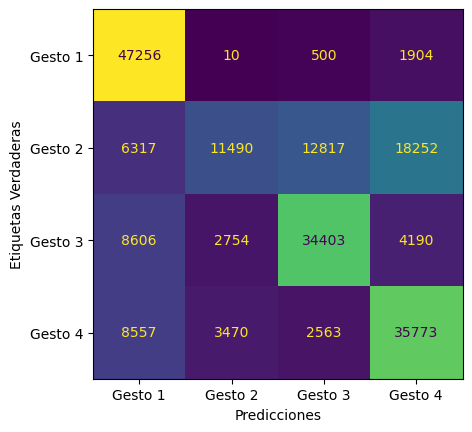

In [79]:
# Muestra la matriz de confusión en una figura
labels = ['Gesto 1', 'Gesto 2', 'Gesto 3', 'Gesto 4'] # Etiquetas correctas para las clases
cm_display = ConfusionMatrixDisplay(confusion_matrix = x, display_labels=labels)

cm_display.plot(colorbar=False)
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.show()

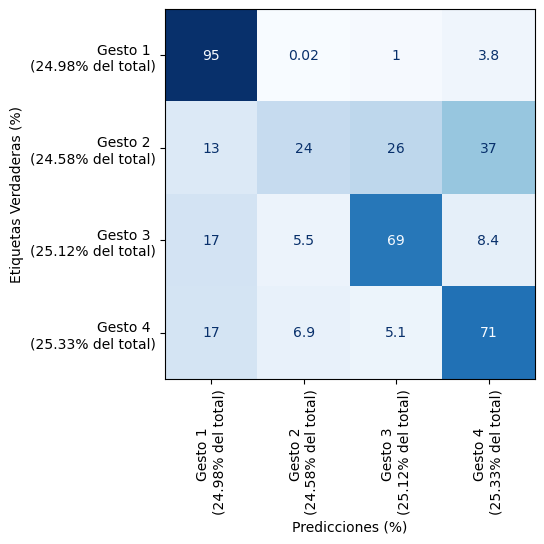

In [80]:
# Normaliza la matriz de confusión para obtener porcentajes
cm_norm = x.astype('float') / x.sum(axis=1)[:, np.newaxis] * 100

# Calcular la suma de cada fila para obtener el número total de predicciones para cada clase
total_predictions_per_class = x.sum(axis=1)

# Calcular el porcentaje que representa cada fila en la cantidad total de datos del conjunto
total_data = total_predictions_per_class.sum()
percentages_per_class = (total_predictions_per_class / total_data) * 100

# Crear una lista de etiquetas con los porcentajes
labels_with_percentages = [f'{label} \n({percent:.2f}% del total)' for label, percent in zip(labels, percentages_per_class)]

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels_with_percentages)

cm_display.plot(cmap='Blues',xticks_rotation='vertical', colorbar=False)  # Lo colocamos azul para distinguir

plt.xlabel('Predicciones (%)')
plt.ylabel('Etiquetas Verdaderas (%)')


plt.show()

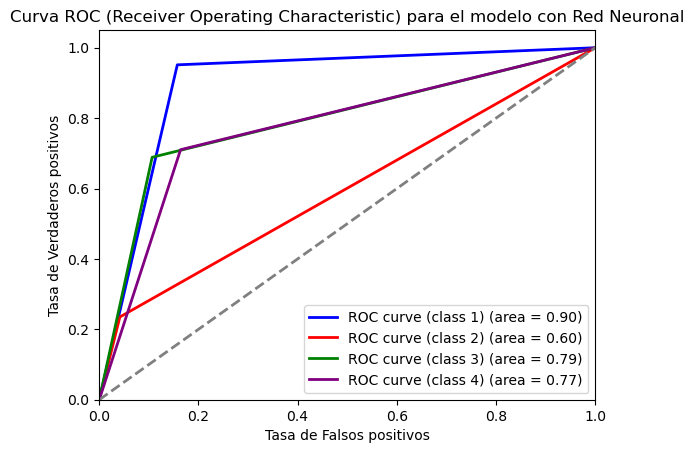

In [105]:
#PLOTEA LA CURVA ROC DE LA MATRIZ DE CONFUSION
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

test_y_bin = label_binarize(test_classes, classes=[1, 2, 3, 4])
all_predictions_onehot= label_binarize(predictions, classes=[1, 2, 3, 4])


for i in range(4):  # 4 clases o gestos para clasificar
    fpr[i], tpr[i], _ = roc_curve(test_y_bin[:, i], all_predictions_onehot[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotea la curva ROC para cada clase
plt.figure()
colors = ['blue', 'red', 'green', 'purple']  # Ajusta los colores
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (class {0}) (area = {1:0.2f})'.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos positivos')
plt.ylabel('Tasa de Verdaderos positivos')
plt.title('Curva ROC (Receiver Operating Characteristic) para el modelo con Red Neuronal')
plt.legend(loc="lower right")
plt.show()

In [106]:
#GUARDANDO LAS PREDICCIONES QUE HIZO DEL TEST_X PARA FUTURAS COMPARACIONES
np.save('PREDICTIONS_NB.npy', predictions)  
np.save('PREDICTIONS_NB_onehot.npy', all_predictions_onehot)  